In [23]:
import numpy as np 
import h5py
import torch
import matplotlib.pyplot as plt
from scipy.linalg import eigh, inv 
from colorsys import hls_to_rgb
import time


In [24]:
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # --> array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c
    
def parse_key_string(key_string):
    # Remove the brackets and split the string by commas
    key_list = key_string.strip('[]').split(', ')
    # Convert the string elements to integers
    key_list = [int(x) for x in key_list]
    # Extract R, i, j
    R = key_list[:3]
    i = key_list[3]
    j = key_list[4]
    return R, i, j
def make_hermitian(X):
    return 0.5*(X + np.conj(X.T))

# class generalized_eigen_problem:

#     def __init__(self, A, B):
#         # A Phi = B Phi Lambda --> Phi: eigenvectors, Lambda: eigenvalues
#         self.A = A
#         self.B = B

#     def solve(self):
#         Phi_B, Lambda_B = self.eigen_decomposition(matrix=self.B)
#         lambda_B = Lambda_B.diagonal()
#         a = lambda_B**0.5
#         a = np.nan_to_num(a) + 0.0001
#         # Lambda_B_squareRoot = np.diag(lambda_B**0.5)
#         Lambda_B_squareRoot = np.diag(a)
#         Phi_B_hat = Phi_B.dot(inv(Lambda_B_squareRoot))
#         A_hat = (Phi_B_hat.T).dot(self.A).dot(Phi_B_hat)
#         Phi_A, Lambda_A = self.eigen_decomposition(matrix=A_hat)
#         Lambda = Lambda_A
#         Phi = Phi_B_hat.dot(Phi_A)
#         return Phi, Lambda

#     def solve_dirty(self):
#         C = inv(self.B).dot(self.A)
#         epsilon = 0.00001  # --> to prevent singularity of matrix C
#         C = C + epsilon * np.eye(C.shape[0])
#         Phi, Lambda = self.eigen_decomposition(matrix=C)
#         return Phi, Lambda

#     def eigen_decomposition(self, matrix):
#         eig_val, eig_vec = eigh(matrix)
#         idx = eig_val.argsort()[::-1]  # sort eigenvalues in descending order (largest eigenvalue first)
#         eig_val = eig_val[idx]
#         eig_vec = eig_vec[:, idx]
#         Eigenvectors = eig_vec
#         eigenvalues = eig_val
#         eigenvalues = np.asarray(eigenvalues)
#         Eigenvalues = np.diag(eigenvalues)
#         return Eigenvectors, Eigenvalues

In [27]:
# Define file paths
file_path1 = '../example2/work_dir/dataset/processed/0/hamiltonians.h5'
file_path2 = '../example2/work_dir/dataset/processed/0/overlaps.h5'

kx = np.linspace(-0.4,0.4,5)
ky = kx
kz = 0
ky_grid,  kx_grid= np.meshgrid(kx, ky)

kx_flat = kx_grid.flatten()
ky_flat = ky_grid.flatten()
kz_flat = np.full(kx_flat.shape, kz)

# Combine into a single array
k_vec = np.vstack((kx_flat, ky_flat, kz_flat)).T
# print(k_vec)

#### Parse R i j
row = [] # For sparse matrix
col = [] # For sparse matrix
with h5py.File(file_path1, 'r') as file:
    R_vec = []
    list_keys = list(file.keys())
    for i in list_keys:
        R, I, J = parse_key_string(i)
        R_vec.append(R)
        row.append(I-1)
        col.append(J-1)

# Open both files using h5py in read mode ('r')
with h5py.File(file_path1, 'r') as ham, h5py.File(file_path2, 'r') as olp:
    start_time = time.time()
    # Example: List the keys (datasets/groups) in each file
    list_keys_ham = list(ham.keys())
    list_keys_olp = list(olp.keys())
    # Read the dataset
    mask = len(olp[list_keys_olp[0]][:])
    Hk = np.zeros(((mask)*2, (mask)*2, len(k_vec)),dtype=complex)
    olpk = np.zeros(((mask), (mask), len(k_vec)),dtype=complex)
    for k in range(len(k_vec)):
        for i in range(len(list_keys_ham)): # loop over all R coord. 
            olp_matrix = olp[list_keys_olp[i]][:]
            for s1 in range(2): # consider SOC, we parse Hamiltonian into 4 block. 
                for s2 in range(2):                                
                    parse_ham = ham[list_keys_ham[i]][(s1)*mask:(s1+1)*mask,(s2)*mask:(s2+1)*mask]
                    #sum over R -> Fourier Transform from R to k
                    Hk[(s1)*mask:(s1+1)*mask,(s2)*mask:(s2+1)*mask,k] += np.exp( 1j * k_vec[k] @ R_vec[i]) * parse_ham
            #sum over R -> Fourier Transform from R to k
            olpk[:,:,k] += np.exp( 1j * 2*np.pi * k_vec[k] @ R_vec[i]) * olp_matrix
    end_time = time.time()
print(f"Elapsed time: {end_time-start_time:.2f} seconds")


# eigvecs, eigvals = generalized_eigen_problem(parse_ham_hermi, olp_matrix_hermi).solve_dirty()
# print(np.sum(np.diag(eigvals)))

# eigvals, eigvecs = eigh(parse_ham_hermi, olp_matrix_hermi, eigvals_only=False)
# Convert the complex data to an RGB image
# img = colorize(Hk[:,:,k])
# plt.figure(figsize=(8, 6))
# # Plot the image
# plt.imshow(img)
# plt.title('$H_{i\\alpha, j\\beta}$',fontsize=20)
# # Display the plot
# plt.show()

Elapsed time: 36.79 seconds


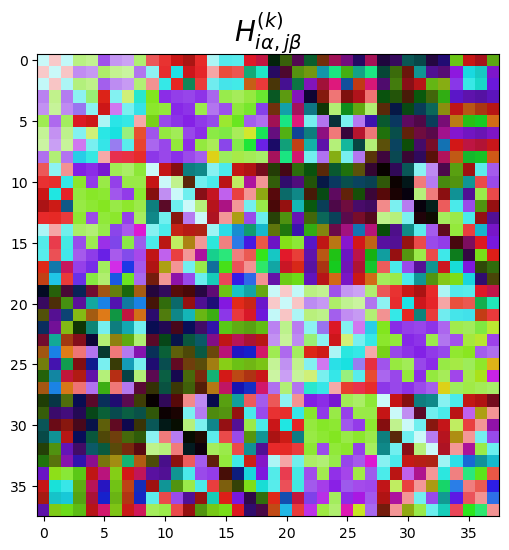

In [26]:
img = colorize(Hk[:,:,0])
plt.figure(figsize=(8, 6))
# Plot the image
plt.imshow(img)
plt.title('$H^{(k)}_{i\\alpha, j\\beta}$',fontsize=20)
# Display the plot
plt.show()

In [5]:
# For every k point, we have a set of KS equation
start_time = time.time()
total_energy = 0
for k in range(len(k_vec)):
    for s1 in range(2): # consider SOC, we parse Hamiltonian into 4 block. 
        for s2 in range(2):                                
            parse_ham_k = Hk[(s1)*mask:(s1+1)*mask,(s2)*mask:(s2+1)*mask,k]
            eigvals, eigvecs = eigh(parse_ham_k, olpk[:,:,k])
            total_energy += np.sum(eigvals)

print(total_energy)
end_time = time.time()
print(f"Elapsed time: {end_time-start_time:.2f} seconds")

-5898.199793880133
Elapsed time: 0.20 seconds


In [ ]:
## Think the above approach is wrong, we never use the I, J information 

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Define the size of each block and the overall sparse matrix
block_size = 19
num_blocks = 36*36
matrix_size = block_size * num_blocks

# Initialize the sparse matrix using LIL (List of Lists) format for efficient construction
sparse_matrix = lil_matrix((matrix_size, matrix_size))

# Define the I, J coordinates and the corresponding values
I = [0, 1, 2]  # Example row indices of blocks
J = [0, 1, 2]  # Example column indices of blocks

# Fill the sparse matrix with blocks
for i, j in zip(row[:2], col[:2]):
    # Define the block matrix
    block_matrix = np.random.rand(block_size, block_size)  # Example: Random block, you can customize it

    # Calculate the start indices in the sparse matrix
    row_start = i * block_size
    col_start = j * block_size

    # Place the block in the sparse matrix
    sparse_matrix[row_start:row_start+block_size, col_start:col_start+block_size] = block_matrix
    print('done')
# Convert the matrix to CSR (Compressed Sparse Row) format for efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()

# Ensure the matrix is symmetric (for demonstration, let's symmetrize it)
sparse_matrix = (sparse_matrix + sparse_matrix.T) / 2

# Compute the k largest eigenvalues and corresponding eigenvectors
k = 6  # Number of eigenvalues and eigenvectors to compute
eigenvalues, eigenvectors = eigsh(sparse_matrix, k=k, which='LM')  # 'LM' for Largest Magnitude

print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)
